# Test: Analytical Coagulation Kernels

The Smoluchwoski equation has analytical solutions for three special cases: the constant, the linear, and the product kernels.
These can be used to verify the coagulation algorithm of `DustPy`.

In this notebook we are going to implement the constant and the linear kernel to demonstrate the diffusivity of the coagulation algorithm.

Dust growth is implemented by solving the Smolukowski equation for a particle mass distribution

$\begin{split}
\frac{\partial}{\partial t} N\left( m \right) = &\int\limits_0^\infty \int\limits_0^{m'} M\left( m, m', m'' \right) N\left( m' \right) N\left( m'' \right) K\left( m', m'' \right) \mathrm{d}m'' \mathrm{d}m'\\
&-N\left( m \right) \int\limits_0^\infty N\left( m' \right) K\left( m, m' \right) \mathrm{d}m'.
\end{split}$

When only considering sticking collisions, the matrix $M$ can be expressed with a $\delta$-function

$M\left(m,m',m''\right) = \delta\left(m-m'-m''\right)$,  

meaning masses $m'$ and $m''$ collide to form a particle of mass $m$.

Using this, the Smoluchowski equation can be simplified to

$\begin{split}
\frac{\partial}{\partial t} N\left( m \right) = &\int\limits_0^\infty N\left( m-m' \right) N\left( m' \right) K\left( m-m', m' \right) \mathrm{d}m'\\
&-N\left( m \right) \int\limits_0^\infty N\left( m' \right) K\left( m, m' \right) \mathrm{d}m'.
\end{split}$

This equation has analytical solutions for some choices of the kernel $K$ and can be used to benchmark the coagulation algorithm against. The solutions and their derivations are discussed in detail in e.g. [Silk & Takahashi (1979)](https://doi.org/10.1086/156949) or [Wetherill (1990)](https://doi.org/10.1016/0019-1035(90)90086-O).

## The Constant Kernel

The most simple kernel is the constant kernel given by

$K\left(m, m'\right) = a$.

In this case the Smoluchowski equation has the solution

$N\left(m, t\right) = \frac{N_0}{m_0} \left( \frac{2}{aN_0t} \right)^2 \exp \left[\frac{2}{aN_0t} \left( 1 - \frac{m}{m_0} \right) \right]$,

where $m_0$ is the mass of the smallest mass bin. $N_0$ is the total number density of fragments in the beginning

$N_0 = \int\limits_0^\infty N\left(m,0\right)\mathrm{d}m$.

For $t=0$ only the zeroth mass bin is filled.

We can now write a function to compare `DustPy` against the analytical solution. Note that `DustPy` is calculating in units of $Nm\Delta m$, where the bin size $\Delta m$ on a logarithmic mass grid is given by $Bm$ with a grid constant $B$. To make the solution independent of the grid resolution $B$, we are going to plot $N\left(m, t\right)m^2$ in all cases.

In [1]:
import numpy as np

In [2]:
def convert(S, m):
    """Function converts the Dustpy units into number densities.
    
    Parameters
    ----------
    S : array
        Integrated surface density in DustPy units
    m : array
        mass grid
        
    Returns
    -------
    Nm2 : array
        Simulation results in desired units for comparison"""
    A = np.mean(m[1:]/m[:-1])
    B = 2 * (A-1) / (A+1)
    return S / B

We also need a function for the analytical solution.

In [3]:
def solution_constant_kernel(t, m, a, S0):
    """Analytical solution of the constant collision kernel R(m, m') = a.
    Initial condition is that only the zeroth mass bin is filled.
    
    Parameters
    ----------
    t : float
        Time
    m : Field
        Mass grid
    a : float
        Kernel constant
    S0 : float
        Total dust surface density
        
    Returns
    -------
    Nm2 : Field
        Analytical solution in desired units."""
    m0 = m[0]
    N0 = S0 / m0
    return N0 / m0 * 4./(a*N0*t)**2 * np.exp( (1.-m/m0) * 2/(a*N0*t) ) * m**2

With this we can now write a function that modifies a `DustPy` simulation object to set it up for the constant kernel.
Technically, it is possible to start the simulation at $t=0$ and have only the zeroth mass bin filled. However, this will lead to a spiky mass distribution at the low mass end, since the resulting mass of a collision between two zeroth mass bin particles can be significantly larger than the first mass bin, leaving it empty throughout the simulation.

To avoid this, we start the simulation at $t>0$ and use the analytical solution as initial condition.

In [4]:
def set_constant_kernel(sim, a, S0):
    """Function set the ``DustPy`` simulation object up for the constant collision kernel R(m, m') = a.
    
    sim : Frame
        Simulation object
    a : float
        Kernel constant
    S0 : float
        Total dust surface density"""
    # Turning off gas evolution by removing integrator instruction
    del(sim.integrator.instructions[1])
    # Turning off gas source to not influence the time stepping
    sim.gas.S.tot[...] = 0.
    sim.gas.S.tot.updater = None
    # Turning off dust advection
    sim.dust.v.rad[...] = 0.
    sim.dust.v.rad.updater = None
    # Turning off fragmentation. Only sticking is considered
    sim.dust.p.frag[...] = 0.
    sim.dust.p.frag.updater = None
    sim.dust.p.stick[...] = 1.
    sim.dust.p.stick.updater = None
    # Setting the constant kernel
    sim.dust.kernel[...] = a
    sim.dust.kernel.updater = None
    # Setting the initial time
    sim.t = 1.e-9
    # Setting the initial dust surface density
    m = sim.grid.m
    A = np.mean(m[1:]/m[:-1])
    B = 2 * (A-1) / (A+1)
    sim.dust.Sigma[...] = sim.dust.SigmaFloor[...]
    sim.dust.Sigma[1, :] = np.maximum(solution_constant_kernel(sim.t, m, a, S0)*B, sim.dust.Sigma[1, :])
    # Updating the simulation object
    sim.update()

We can now create a simulation object

In [5]:
from dustpy import Simulation

In [6]:
sim = Simulation()

We need one radial grid cells to compare the simulation to the analytical solution and two grid cells as boundaries.

In [7]:
sim.ini.grid.Nr = 3

For this exercise, we do not want to remove particles initially that are close to the drift barrier.

In [8]:
sim.ini.dust.allowDriftingParticles = False

In [9]:
sim.initialize()

Now we set the constant kernel with a kernel constant of $a=1$ and a surface density of $S_0=1$.

In [10]:
a = 1.
S0 = 1.

In [11]:
set_constant_kernel(sim, a, S0)

We set custom timesteps

In [12]:
snapshots = np.logspace(-7., 3., 6)
sim.t.snapshots = snapshots

and define the output directory.

In [13]:
sim.writer.datadir = "test_constant_kernel"

The simulation is now ready to go.

In [14]:
sim.run()


DustPy v1.0.0

Documentation: https://stammler.github.io/dustpy/
PyPI:          https://pypi.org/project/dustpy/
GitHub:        https://github.com/stammler/dustpy/

Please cite Stammler & Birnstiel (2021)

Checking for mass conservation...

    - Sticking:
        max. rel. error:  2.81e-14
        for particle collision
            m[114] =  1.93e+04 g    with
            m[116] =  3.73e+04 g
    - Full fragmentation:
        max. rel. error:  4.44e-16
        for particle collision
            m[47] =  5.18e-06 g    with
            m[54] =  5.18e-05 g
    - Cratering:
        max. rel. error:  1.78e-15
        for particle collision
            m[110] =  5.18e+03 g    with
            m[118] =  7.20e+04 g

Creating data directory 'test_constant_kernel'.
Writing file test_constant_kernel/data0000.hdf5
Writing dump file test_constant_kernel/frame.dmp
Writing file test_constant_kernel/data0001.hdf5
Writing dump file test_constant_kernel/frame.dmp
Writing file test_constant_kernel/data

We now read the necessary data and plot it.

In [15]:
SigmaConstant = sim.writer.read.sequence("dust.Sigma")
m = sim.writer.read.sequence("grid.m")
t = sim.writer.read.sequence("t")

In [16]:
import matplotlib.pyplot as plt

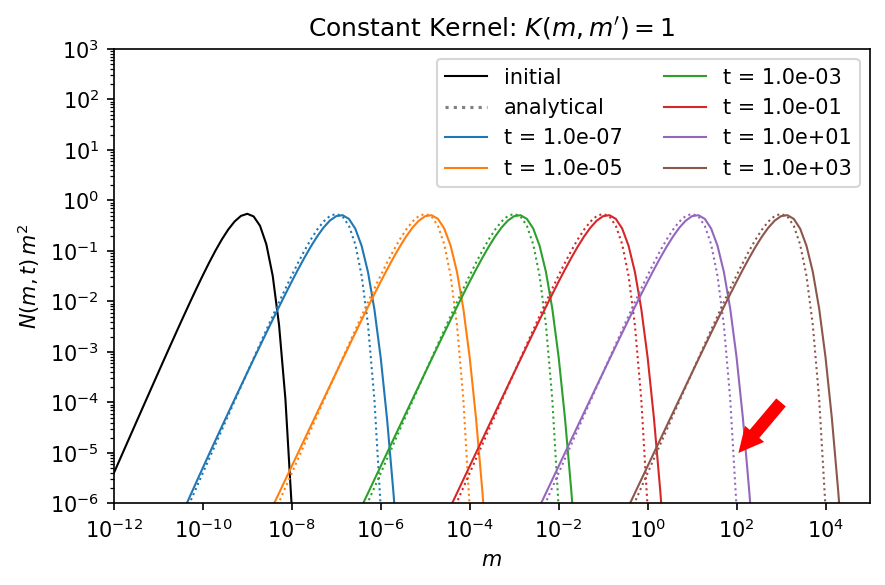

In [17]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.loglog(m[0, ...], convert(SigmaConstant[0, 1, :], m[0, ...]), lw=1, c="black", label="initial")
ax.plot(0., 0., ":", c="black", label="analytical", alpha=0.5)
for i in range(1, len(t)):
    cstr = "C" + str(i-1)
    ax.loglog(m[i, ...], convert(SigmaConstant[i, 1, :], m[i, ...]), lw=1, c=cstr, label="t = {:3.1e}".format(t[i]))
    ax.loglog(m[i, ...], solution_constant_kernel(t[i], m[i, ...], a, S0), ":", lw=1, c=cstr)
ax.annotate('', xy=(1.1e2, 1.e-5), xytext=(1.e3, 1.e-4), arrowprops=dict(facecolor='red', lw="0", width=6))
ax.legend(ncol=2)
ax.set_xlim(m[0, 0], m[0, -1])
ax.set_ylim(1.e-6, 1.e3)
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$N\left(m,t\right)\,m^2$")
ax.set_title(r"Constant Kernel: $K\left( m, m'\right) = 1$")
fig.tight_layout()

As marked by the red arrow, the upper end of the mass distribution is a bit off from the analytical solution. The reason for that is, that on a logarithmic mass grid the sum of two colliding masses will lie between two mass bins and has to be distributed between them. That means that a mass bin will be filled that is larger than the combined mass of both collision partners. This leads to accelerated particles growth.

To counteract this, the mass resolution can be increased. In the following example we are running the same simulation again but with 28 mass bins per mass decade. Default is 7.

In [18]:
sim = Simulation()

In [19]:
sim.ini.grid.Nr = 3
sim.ini.grid.Nmbpd = 28

In [20]:
sim.ini.dust.allowDriftingParticles = False

In [21]:
sim.initialize()

In [22]:
set_constant_kernel(sim, a, S0)

In [23]:
sim.t.snapshots = snapshots

In [24]:
sim.writer.datadir = "test_constant_kernel_high_res"

In [25]:
sim.run()


DustPy v1.0.0

Documentation: https://stammler.github.io/dustpy/
PyPI:          https://pypi.org/project/dustpy/
GitHub:        https://github.com/stammler/dustpy/

Please cite Stammler & Birnstiel (2021)

Checking for mass conservation...

    - Sticking:
        max. rel. error:  5.90e-14
        for particle collision
            m[443] =  6.63e+03 g    with
            m[472] =  7.20e+04 g
    - Full fragmentation:
        max. rel. error:  1.33e-15
        for particle collision
            m[468] =  5.18e+04 g    with
            m[475] =  9.21e+04 g
    - Cratering:
        max. rel. error:  5.44e-15
        for particle collision
            m[431] =  2.47e+03 g    with
            m[462] =  3.16e+04 g

Creating data directory 'test_constant_kernel_high_res'.
Writing file test_constant_kernel_high_res/data0000.hdf5
Writing dump file test_constant_kernel_high_res/frame.dmp
Writing file test_constant_kernel_high_res/data0001.hdf5
Writing dump file test_constant_kernel_high_res/f

In [26]:
SigmaConstantHighRes = sim.writer.read.sequence("dust.Sigma")
mHighRes = sim.writer.read.sequence("grid.m")
tHighRes = sim.writer.read.sequence("t")

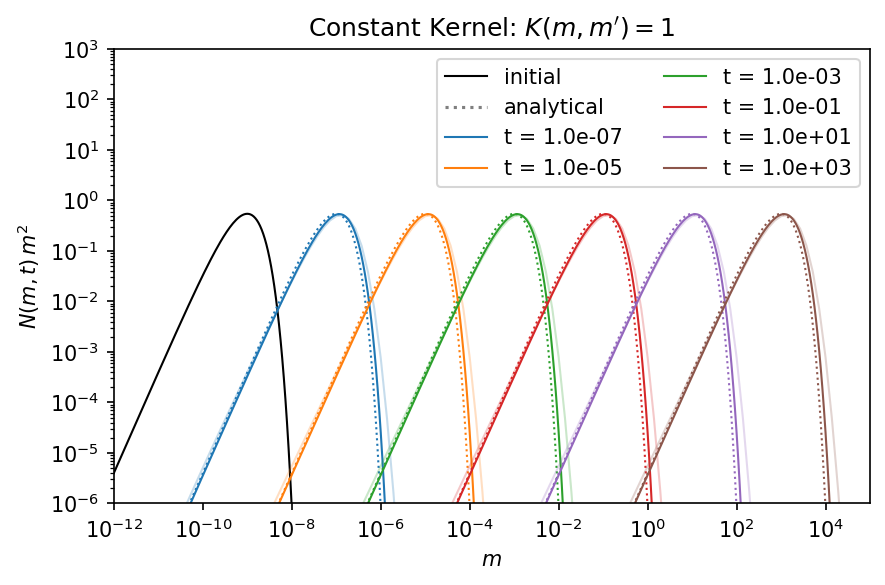

In [27]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.loglog(mHighRes[0, ...], convert(SigmaConstantHighRes[0, 1, :], mHighRes[0, ...]), lw=1, c="black", label="initial")
ax.plot(0., 0., ":", c="black", label="analytical", alpha=0.5)
for i in range(1, len(tHighRes)):
    cstr = "C" + str(i-1)
    ax.loglog(mHighRes[i, ...], convert(SigmaConstantHighRes[i, 1, :], mHighRes[i, ...]), lw=1, c=cstr, label="t = {:3.1e}".format(tHighRes[i]))
    ax.loglog(m[i, ...], convert(SigmaConstant[i, 1, :], m[i, ...]), lw=1, c=cstr, alpha=0.25)
    ax.loglog(mHighRes[i, ...], solution_constant_kernel(t[i], mHighRes[i, ...], a, S0), ":", lw=1, c=cstr)
ax.legend(ncol=2)
ax.set_xlim(mHighRes[0, 0], mHighRes[0, -1])
ax.set_ylim(1.e-6, 1.e3)
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$N\left(m,t\right)\,m^2$")
ax.set_title(r"Constant Kernel: $K\left( m, m'\right) = 1$")
fig.tight_layout()

In the high resolution case the simulation is way closer to the analytical solution compared to the semi-transparent solid lines of the low resolution simulation. This comes of course with the cost of a more expensive computation. If you need a higher resolution depends on your collision model. For a detail discussion on this problem we refer to [Drążkowska et al. (2014)](https://doi.org/10.1051/0004-6361/201423708).

## The Linear Kernel

The second kernel that has an analytical solution it the linear kernel

$R\left(m, m'\right) = a\left(m + m'\right)$

with the analytical solution

$N\left(m , t\right) = \frac{N_0}{2\sqrt{\pi}m_0^2} \frac{g}{\left(1-g\right)^\frac{3}{4}} \exp \left[-\frac{m}{m_0}\left(1-\sqrt{1-g}\right)^2 \right]$

with

$g = \exp \left[ -aN_0m_0t \right]$.

In [28]:
def solution_linear_kernel(t, m, a, S0):
    """Analytical solution of the linear collision kernel R(m, m') = a(m + m').
    Initial condition is that only the zeroth mass bin is filled.
    
    Parameters
    ----------
    t : float
        Time
    m : Field
        Mass grid
    a : float
        Kernel constant
    S0 : float
        Total dust surface density
        
    Returns
    -------
    Nm2 : Field
        Analytical solution in desired units."""
    m0 = m[0]
    N0 = S0/m0**2
    g = np.exp(-a*S0*t)
    #N = 1./m0**2 * g * np.exp( -m/m0 * ( 1. - np.sqrt(1-g) )**2 ) / ( 2.*np.sqrt(np.pi) * (m/m0)**1.5 * (1.-g)**0.75 )
    N = N0 * g * np.exp( -m/m0 * ( 1. - np.sqrt(1-g) )**2 ) / ( 2.*np.sqrt(np.pi) * (m/m0)**1.5 * (1.-g)**0.75 )
    return N*m**2

In [29]:
def set_linear_kernel(sim, a, S0):
    """Function set the ``DustPy`` simulation object up for the linear collision kernel R(m, m') = a(m + m').
    
    sim : Frame
        Simulation object
    a : float
        Kernel constant
    S0 : float
        Total dust surface density"""
    # Turning off gas evolution by removing integrator instruction
    del(sim.integrator.instructions[1])
    # Turning off gas source to not influence the time stepping
    sim.gas.S.tot[...] = 0.
    sim.gas.S.tot.updater = None
    # Turning off dust advection
    sim.dust.v.rad[...] = 0.
    sim.dust.v.rad.updater = None
    # Turning off fragmentation. Only sticking is considered
    sim.dust.p.frag[...] = 0.
    sim.dust.p.frag.updater = None
    sim.dust.p.stick[...] = 1.
    sim.dust.p.stick.updater = None
    # Setting the constant kernel
    sim.dust.kernel[...] = a * (sim.grid.m[:, None] + sim.grid.m[None, :])[None, ...]
    sim.dust.kernel.updater = None
    # Setting the initial dust surface density
    sim.dust.Sigma[...] = sim.dust.SigmaFloor[...]
    m = sim.grid.m
    A = np.mean(m[1:]/m[:-1])
    B = 2 * (A-1) / (A+1)
    sim.t = 0.9
    sim.dust.Sigma[1, ...] = np.maximum(solution_linear_kernel(sim.t, m, a, S0) * B, sim.dust.SigmaFloor[1, ...])
    # Updating the simulation object
    sim.update()

In [30]:
sim = Simulation()

In [31]:
sim.ini.grid.Nr = 3
sim.ini.dust.allowDriftingParticles = True

In [32]:
sim.initialize()

In [33]:
set_linear_kernel(sim, a, S0)

In [34]:
snapshots = np.logspace(0., 1., 6)
sim.t.snapshots = snapshots

In [35]:
sim.writer.datadir = "test_linear_kernel"

In [36]:
sim.run()


DustPy v1.0.0

Documentation: https://stammler.github.io/dustpy/
PyPI:          https://pypi.org/project/dustpy/
GitHub:        https://github.com/stammler/dustpy/

Please cite Stammler & Birnstiel (2021)

Checking for mass conservation...

    - Sticking:
        max. rel. error:  2.81e-14
        for particle collision
            m[114] =  1.93e+04 g    with
            m[116] =  3.73e+04 g
    - Full fragmentation:
        max. rel. error:  4.44e-16
        for particle collision
            m[47] =  5.18e-06 g    with
            m[54] =  5.18e-05 g
    - Cratering:
        max. rel. error:  1.78e-15
        for particle collision
            m[110] =  5.18e+03 g    with
            m[118] =  7.20e+04 g

Creating data directory 'test_linear_kernel'.
Writing file test_linear_kernel/data0000.hdf5
Writing dump file test_linear_kernel/frame.dmp
Writing file test_linear_kernel/data0001.hdf5
Writing dump file test_linear_kernel/frame.dmp
Writing file test_linear_kernel/data0002.hdf5
Wr

In [37]:
SigmaLinear = sim.writer.read.sequence("dust.Sigma")
m = sim.writer.read.sequence("grid.m")
t = sim.writer.read.sequence("t")

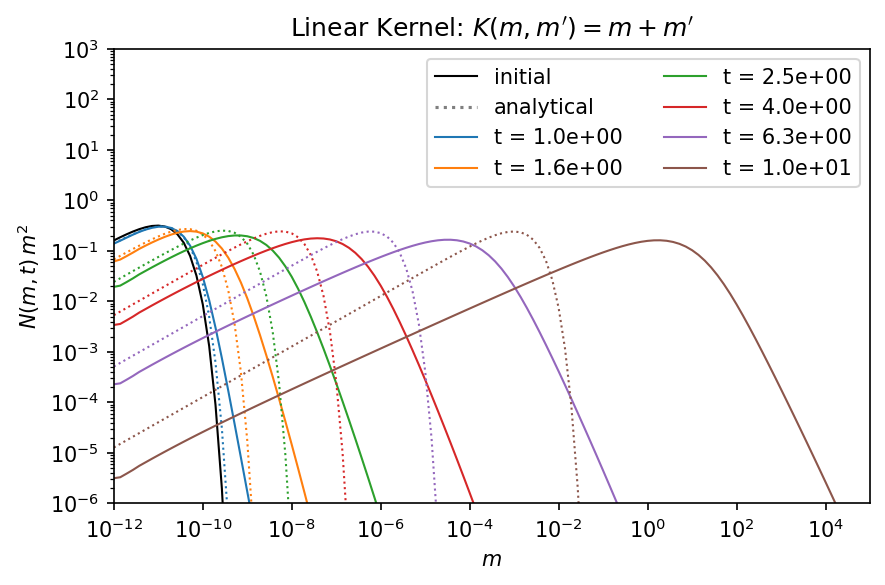

In [38]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.loglog(m[0, ...], convert(SigmaLinear[0, 1, :], m[0, ...]), lw=1, c="black", label="initial")
ax.plot(0., 0., ":", c="black", label="analytical", alpha=0.5)
for i in range(1, len(t)):
    cstr = "C" + str(i-1)
    ax.loglog(m[i, ...], convert(SigmaLinear[i, 1, :], m[i, ...]), lw=1, c=cstr, label="t = {:3.1e}".format(t[i]))
    ax.loglog(m[i, ...], solution_linear_kernel(t[i], m[i, ...], a, S0), ":", lw=1, c=cstr)
ax.legend(ncol=2)
ax.set_xlim(m[0, 0], m[0, -1])
ax.set_ylim(1.e-6, 1.e3)
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$N\left(m,t\right)\, m^2$")
ax.set_title(r"Linear Kernel: $K\left( m, m'\right) = m + m'$")
fig.tight_layout()

In the case of the linear kernel the diffusion problem is even worse. Again we can improve the situation by increasing the mass resolution.

In [39]:
sim = Simulation()

In [40]:
sim.ini.grid.Nr = 3
sim.ini.grid.Nmbpd = 28

In [41]:
sim.ini.dust.allowDriftingParticles = True

In [42]:
sim.initialize()

In [43]:
set_linear_kernel(sim, a, S0)

In [44]:
snapshots = np.logspace(0., 1., 6)
sim.t.snapshots = snapshots

In [45]:
sim.writer.datadir = "test_linear_kernel_high_res"

In [46]:
sim.run()


DustPy v1.0.0

Documentation: https://stammler.github.io/dustpy/
PyPI:          https://pypi.org/project/dustpy/
GitHub:        https://github.com/stammler/dustpy/

Please cite Stammler & Birnstiel (2021)

Checking for mass conservation...

    - Sticking:
        max. rel. error:  5.90e-14
        for particle collision
            m[443] =  6.63e+03 g    with
            m[472] =  7.20e+04 g
    - Full fragmentation:
        max. rel. error:  1.33e-15
        for particle collision
            m[468] =  5.18e+04 g    with
            m[475] =  9.21e+04 g
    - Cratering:
        max. rel. error:  5.44e-15
        for particle collision
            m[431] =  2.47e+03 g    with
            m[462] =  3.16e+04 g

Creating data directory 'test_linear_kernel_high_res'.
Writing file test_linear_kernel_high_res/data0000.hdf5
Writing dump file test_linear_kernel_high_res/frame.dmp
Writing file test_linear_kernel_high_res/data0001.hdf5
Writing dump file test_linear_kernel_high_res/frame.dmp
W

In [47]:
SigmaLinearHighRes = sim.writer.read.sequence("dust.Sigma")
mHighRes = sim.writer.read.sequence("grid.m")
tHighRes = sim.writer.read.sequence("t")

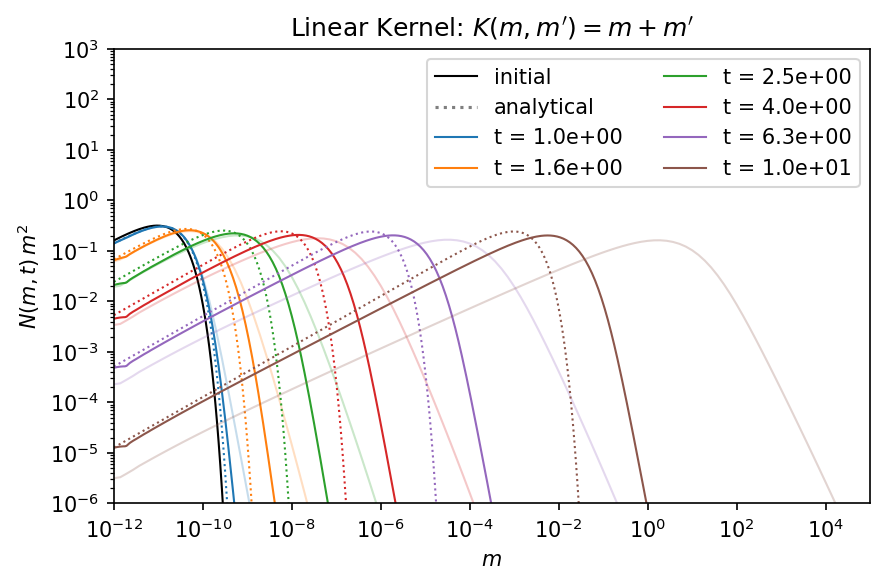

In [48]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.loglog(mHighRes[0, ...], convert(SigmaLinearHighRes[0, 1, :], mHighRes[0, ...]), lw=1, c="black", label="initial")
ax.plot(0., 0., ":", c="black", label="analytical", alpha=0.5)
for i in range(1, len(tHighRes)):
    cstr = "C" + str(i-1)
    ax.loglog(mHighRes[i, ...], convert(SigmaLinearHighRes[i, 1, :], mHighRes[i, ...]), lw=1, c=cstr, label="t = {:3.1e}".format(tHighRes[i]))
    ax.loglog(m[i, ...], convert(SigmaLinear[i, 1, :], m[i, ...]), lw=1, c=cstr, alpha=0.25)
    ax.loglog(mHighRes[i, ...], solution_linear_kernel(t[i], mHighRes[i, ...], a, S0), ":", lw=1, c=cstr)
ax.legend(ncol=2)
ax.set_xlim(mHighRes[0, 0], mHighRes[0, -1])
ax.set_ylim(1.e-6, 1.e3)
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$N\left(m,t\right)\,m^2$")
ax.set_title(r"Linear Kernel: $K\left( m, m'\right) = m + m'$")
fig.tight_layout()

With a higher mass resolution the situation improved significantly.

## The Product Kernel

The third kernel that has an analytical solution it the product kernel

$K\left(m, m'\right) = a \cdot m\times m'$.

This kernel describes runaway growth. In this scenario the mass quickly accumulates in a few massive bodies. Since `DustPy` is not designed to properly simulate individual bodies, this solution will not be discussed here.